In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler

#All Clustering Algo
# from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from sklearn.cluster import AffinityPropagation
# from scipy.cluster.hierarchy import fcluster
# from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# from scipy.spatial.distance import pdist
# from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from itertools import cycle
from itertools import combinations

import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from scipy.stats.mstats import winsorize
import warnings 

warnings.filterwarnings('ignore')

# Import S&P500 Data

In [405]:
# ALL S&P500 data since 2010 (all past tickers)
snp500 = pd.read_csv("../data/raw_hist_snp.csv", on_bad_lines = 'skip')
snp500 = snp500[~snp500.close.isna()]

snp500['date'] = pd.to_datetime(snp500['date'], format='%Y-%m-%d')
snp500['date'] = snp500['date'].dt.date

snp500[['GIC Groups', 'GIC Industries', 'GIC Sectors', 'GIC Sub-Industries']] = \
        snp500[['GIC Groups', 'GIC Industries', 'GIC Sectors', 'GIC Sub-Industries']].fillna(0)

snp500[['GIC Groups', 'GIC Industries', 'GIC Sectors', 'GIC Sub-Industries']] = \
snp500[['GIC Groups', 'GIC Industries', 'GIC Sectors', 'GIC Sub-Industries']].apply(pd.to_numeric, errors='coerce').astype(int)

snp500[['GIC Groups', 'GIC Industries', 'GIC Sectors', 'GIC Sub-Industries']] = \
snp500[['GIC Groups', 'GIC Industries', 'GIC Sectors', 'GIC Sub-Industries']].apply(pd.to_numeric, errors='coerce').astype(str)

print("S&P500 data from ", snp500.date.min(), " to ", snp500.date.max())

S&P500 data from  2010-01-04  to  2023-06-14


In [453]:
snp500.head(1)

,date,gvkey,iid,ticker,company name,ADR Ratio - Daily,shares outstanding,volume,close,high,...,open,GIC Groups,GIC Industries,GIC Sectors,GIC Sub-Industries,NAIC,SIC,S&P Industry Sector Code,S&P Economic Sector Code,market cap
0,2010-01-04,1045,1,AAMRQ,AMERICAN AIRLINES GROUP INC,NaN,332456000.0,17441530.0,7.72,7.79,...,7.73,2030,203020,20,20302010,481111,4512,605.0,600.0,2.566560e+09


# Pairs Identification

In [419]:
def data_window(start, end):
    start_date = pd.to_datetime(start).date()
    end_date = pd.to_datetime(end).date()

    df = snp500[snp500.date.between(start_date,end_date)]
    
    return df

def clean_data(df):    
    ######### Check for Trading Volume #########
    ### Run this filtering the day before rebalancing and return a list of filtered tickers
    
    # Company level average Volume 
#     length = 60 #recent 3 month
#     df_vol = df.tail(length)
    df.volume.fillna(0, inplace=True)
    individual_avg_vol = df.groupby('ticker')['volume'].mean()
    individual_avg_vol = individual_avg_vol.rename('Average Volume')


    # Sector level average Volume 
    sector_avg_vol = df.groupby('GIC Sub-Industries')['volume'].mean()
    sector_avg_vol = sector_avg_vol.rename('Sector Average Volume')

    # Only keep companies in universe if their average volume > sector average volume 
    df = pd.merge(df, individual_avg_vol, on='ticker', how='left')
    df = pd.merge(df, sector_avg_vol, on='GIC Sub-Industries', how='left')

    cleaned_data = df[df["Average Volume"] >= df["Sector Average Volume"]] 
    
    return cleaned_data

def filter_pairs_df(df, watchlist):
    tmp_df = df.copy()
#     filtered_tuples = [t for t in watchlist if all(elem in t for elem in list(tmp_df.ticker.unique()))]
    filtered_tuples = [t for t in watchlist if all(elem in list(tmp_df.ticker.unique()) for elem in t)]
#     print(filtered_tuples)
    
    pairs = []
    for i, j in filtered_tuples:  
        pairs.append(i)
        pairs.append(j)

    data = tmp_df[(tmp_df.ticker.isin(pairs))][['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'market cap']]

    return data, filtered_tuples

def transform_df(df, watchlist=None, flag=True, threshold=100):
    temp_df = df.copy()
    
    if flag == True:
        unique_tuples = set()
    #     all_combi_pairs = list(combinations(list(close_df.columns), 2))
        all_combi_pairs = list(combinations(list(temp_df.ticker.unique()), 2))
        for tup in all_combi_pairs:
            # Sort the tuple elements to ensure consistent order
            sorted_tup = tuple(sorted(tup))
            # Add the sorted tuple to the set
            unique_tuples.add(sorted_tup)
            
        filtered_tuples = list(unique_tuples)
#         print(len(filtered_tuples))
#         print(filtered_tuples[5])
        data = temp_df.copy()
        
    else:    
        data, filtered_tuples = filter_pairs_df(temp_df, list(watchlist))
    
    close_df = data.pivot(index = 'date', columns = 'ticker', values = 'close')
    close_df.dropna(axis=1, thresh=threshold, inplace=True)
    close_df.interpolate(inplace=True)
    close_df.fillna(close_df.mean(), inplace=True)
    
    vol_df = data.pivot(index = 'date', columns = 'ticker', values = 'volume')
    mkt_cap_df = data.pivot(index = 'date', columns = 'ticker', values = 'market cap')

#     updated_tuples = [t for t in filtered_tuples if all(elem in t for elem in list(close_df.columns))]
    updated_tuples = [t for t in filtered_tuples if all(elem in list(close_df.columns) for elem in t)]
#     print(any('FLS' in tpl for tpl in updated_tuples))
#     print("length of updated tuples: ", len(updated_tuples))
        
#     return close_df, list(unique_tuples)
    return close_df, vol_df, mkt_cap_df, updated_tuples

In [415]:
def clustering_pairs(df, pairs, vol_df=pd.DataFrame(), mkt_cap_df=pd.DataFrame(), flag=True):
    # Treat missing values
    df = df.fillna(method = "ffill")
    missing_fractions = df.isnull().mean().sort_values(ascending = False)
    drop_list = sorted(list(missing_fractions[missing_fractions > 0].index))
    df.drop(labels= drop_list, axis=1, inplace = True)
    
    # Generate returns and vol df
    returns = df.pct_change().mean() * 252
    returns = pd.DataFrame(returns)
    returns.columns = ["Returns"]
    
    returns["Volatility"] = df.pct_change().std() * np.sqrt(252)
    
    if not vol_df.empty:
        returns["Volume"] = vol_df.mean()
        
    if not mkt_cap_df.empty:
        returns["Market Cap"] = mkt_cap_df.mean()
    
    data = returns
#     print(data.head())
    
    # Scale df
    scaler = StandardScaler().fit(data)
    rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
    X = rescaledDataset
    
    # Winsorize the df
    X['Returns'] = winsorize(X['Returns'], limits=(0.1, 0.1))
    X['Volatility'] = winsorize(X['Volatility'], limits=(0.1, 0.1))
    
    if not vol_df.empty:
        X['Volume'] = winsorize(X['Volume'], limits=(0.1, 0.1))
        
    if not mkt_cap_df.empty:
        X['Market Cap'] = winsorize(X['Market Cap'], limits=(0.1, 0.1))
    
   ## It is recommended to apply the algorithm to a subset of your data or use dimensionality reduction techniques if needed.
    # ap = AffinityPropagation() 

    ##Can try tuning here (Higher damping factors may lead to fewer clusters but more compact clusters, 
    ##while lower damping factors may result in more clusters but less compactness.)
    ap = AffinityPropagation(damping=0.9, max_iter=200)  
    ap.fit(X)

    clust_labels2 = ap.predict(X)
    # clustered stock with its cluster label
    cluster_centers_indices = ap.cluster_centers_indices_  #coordinates of the identified cluster centers
    labels = ap.labels_  #assigned cluster labels for each sample
    clustered_series_ap = pd.Series(index=X.index, data=ap.labels_.flatten())
    # Identify closest pair in each cluster
    final_pairs = []
    cluster_spread = pd.DataFrame()
    
    
    if flag == True:
        for i in range(0,clustered_series_ap.max() + 1):
            clustered_stocks = clustered_series_ap[clustered_series_ap == i]
            stock_pairs = list(combinations(clustered_stocks.index, 2))

            coint_watchlist, coint_spread_df = cointegration_pairs(df, stock_pairs)
#             print(coint_watchlist)

            # Identify pair in each cluster with shortest Gatev distance measure 
            spread_dict = {}

            #for pair in cointegrated_pairs:
            for pair in coint_watchlist:
                S1 = list(pair)[0]
                S2 = list(pair)[1]
                df2 = df[list(pair)]
                S1_final = df2[S1][-1]
                S2_final = df2[S2][-1]
                df2[S1] = df2[S1] / S1_final
                df2[S2] = df2[S2] / S2_final
                df2["spread"] = (df2[S1] / df2[S2]) -1
                mean_spread = df2["spread"].mean()
                hist_dist = ((df2["spread"] - mean_spread) ** 2).sum()
                spread_dict[pair] = hist_dist
            
            try:
                pair_found = min(spread_dict, key = spread_dict.get)
        #             print(pair_found)
                index = next((i for i, (key, value) in enumerate(spread_dict.items()) if key == pair_found), None)
        #             print(index)
                tmp_df = coint_spread_df.iloc[:, index]
        #             print(tmp_df)
                cluster_spread = pd.concat([cluster_spread, tmp_df], axis=1)
        #             print(cluster_spread)

                final_pairs.append(min(spread_dict, key = spread_dict.get))
            except ValueError:
                print("min() arg is an empty sequence, continuing execution!")
        
    else:
        coint_watchlist, coint_spread_df = cointegration_pairs(df, pairs, flag=False)  #for validation
        
        spread_dict = {}
#         print(len(coint_watchlist))
        #for pair in cointegrated_pairs:
        for pair in coint_watchlist:
            S1 = list(pair)[0]
            S2 = list(pair)[1]
            df2 = df[list(pair)]
            S1_final = df2[S1][-1]
            S2_final = df2[S2][-1]
            df2[S1] = df2[S1] / S1_final
            df2[S2] = df2[S2] / S2_final
            df2["spread"] = (df2[S1] / df2[S2]) -1
            mean_spread = df2["spread"].mean()
            hist_dist = ((df2["spread"] - mean_spread) ** 2).sum()
            spread_dict[pair] = hist_dist
#             print("each dist: ", hist_dist)
            
            if spread_dict[pair] < 3:
                index = next((i for i, (key, value) in enumerate(spread_dict.items()) if key == pair), None)
                tmp_df = coint_spread_df.iloc[:, index]
                cluster_spread = pd.concat([cluster_spread, tmp_df], axis=1)
                print(pair, "gatev dist is: ", hist_dist)
                final_pairs.append(pair)
                
    return final_pairs, cluster_spread


#Correlation Test 
def correlation_pairs(df, unique_tuples, rsq_thresh=0.9, corr_thresh=0.9):
    corr_df = df.copy()
    corr_watchlist = []
    corr_spread_df = pd.DataFrame()
    
    return_df = corr_df.pct_change()
    pairs_corr = return_df.corr()

    for i in range(len(unique_tuples)):
        try:
            X = sm.add_constant(corr_df[unique_tuples[i][0]])
        #     print(filtered_list[i], "i = ", i)
            model = sm.OLS(corr_df[unique_tuples[i][1]], X)
            results = model.fit()

            if (results.rsquared > rsq_thresh):
                # print(results.summary())
                if ((pairs_corr[list(unique_tuples[i])].loc[list(unique_tuples[i])]).iloc[0,1] > corr_thresh):
                    print("Correlation = ", (pairs_corr[list(unique_tuples[i])].loc[list(unique_tuples[i])]).iloc[0,1])                
                    corr_watchlist.append(unique_tuples[i])

                    corr_spread_df["{0}_{1}".format(unique_tuples[i][0], unique_tuples[i][1])] \
                    = corr_df[unique_tuples[i][1]] - results.params[0] \
                    - results.params[1]* corr_df[unique_tuples[i][0]]

                    print("Hedge Ratio (Beta) =", round(results.params[unique_tuples[i][0]], 3), "for", unique_tuples[i])
                    print("Average Distance (Spread) between pair =", round(results.params['const'], 3))
                    print("\n")
        except KeyError:
            print("KeyError: ", corr_df[unique_tuples[i][0]], " got problem, but continuing execution...")

    print(len(corr_watchlist), "Correlated pairs.")
    
    return corr_watchlist, corr_spread_df


#ADF Test
def adf_test(df, one_tuple):
    X = sm.add_constant(df[one_tuple[0]])
    model = sm.OLS(df[one_tuple[1]], X)
    ols_results = model.fit()
    
    spread = df[one_tuple[1]] - ols_results.params[0] \
                - ols_results.params[1]* df[one_tuple[0]]
    
    result = sm.tsa.stattools.adfuller(spread)
    
#     adf_statistic = result[0]
#     p_value = result[1]
#     critical_values = result[4]

#     print("ADF Statistic:", adf_statistic)
#     print("p-value:", p_value)
#     print("Critical Values:")
#     for key, value in critical_values.items():
#         print("{}: {}".format(key, value))
    
    if (result[1] < 0.025):
        return True
    
    else:
        return False

    
#Cointegration Test 
def cointegration_pairs(df, unique_tuples, flag=True):
    coint_df = df.copy()
    coint_watchlist = []
    coint_spread_df = pd.DataFrame()

    for i in range(len(unique_tuples)):
        if flag == False:
            X = sm.add_constant(coint_df[unique_tuples[i][0]])
            model = sm.OLS(coint_df[unique_tuples[i][1]], X)
            results = model.fit()

            coint_spread_df["{0}_{1}".format(unique_tuples[i][0], unique_tuples[i][1])] \
                = coint_df[unique_tuples[i][1]] - results.params[0] \
                - results.params[1]* coint_df[unique_tuples[i][0]]

            coint_watchlist.append(unique_tuples[i])
        
        else:
            if (adf_test(coint_df, unique_tuples[i]) == True):
                # Perform the Engle-Granger test for cointegration
                result = coint(coint_df[unique_tuples[i][0]], coint_df[unique_tuples[i][1]])

                if (result[1] < 0.025):

                    X = sm.add_constant(coint_df[unique_tuples[i][0]])
                    model = sm.OLS(coint_df[unique_tuples[i][1]], X)
                    results = model.fit()

                    coint_spread_df["{0}_{1}".format(unique_tuples[i][0], unique_tuples[i][1])] \
                        = coint_df[unique_tuples[i][1]] - results.params[0] \
                        - results.params[1]* coint_df[unique_tuples[i][0]]

                    coint_watchlist.append(unique_tuples[i])

    print(len(coint_watchlist), "Cointegrated pairs.")
    
    return coint_watchlist, coint_spread_df

In [320]:
#Define data windows
train_start = '2020-01-01'
train_end = '2021-06-30'
validate_start = '2021-07-01'
validate_end = '2021-12-31'

train_df = data_window(train_start, train_end) 
validate_df = data_window(validate_start, validate_end)

train_df = clean_data(train_df)
final_train_df, vol_df, mkt_cap_df pairs_combination = transform_df(train_df, threshold=200)

cluster_watchlist, _ = clustering_pairs(final_train_df, pairs_combination)
cluster_vol_watchlist, _ = clustering_pairs(final_train_df, pairs_combination, vol_df)
cluster_mc_watchlist, _ = clustering_pairs(final_train_df, pairs_combination, vol_df, mkt_cap_df)
corr_watchlist, _ = correlation_pairs(final_train_df, pairs_combination)
coint_watchlist, _ = cointegration_pairs(final_train_df, pairs_combination)

validate_df = clean_data(validate_df)

final_validate_df, _, _, updated_cluster_watchlist = transform_df(validate_df, cluster_watchlist, flag=False)
final_validate_df, _, _, updated_cluster_vol_watchlist = transform_df(validate_df, cluster_vol_watchlist, flag=False)
final_validate_df, _, _, updated_cluster_mc_watchlist = transform_df(validate_df, cluster_mc_watchlist, flag=False)
final_validate_df, _, _, updated_corr_watchlist = transform_df(validate_df, corr_watchlist, flag=False)
final_validate_df, _, _, updated_coint_watchlist = transform_df(validate_df, coint_watchlist, flag=False)

_, cluster_spread_df = clustering_pairs(final_validate_df, updated_cluster_watchlist, flag=False)
_, cluster_vol_spread_df = clustering_pairs(final_validate_df, updated_cluster_vol_watchlist, flag=False)
_, cluster_mc_spread_df = clustering_pairs(final_validate_df, updated_cluster_mc_watchlist, flag=False)
_, corr_spread_df = correlation_pairs(final_validate_df, updated_corr_watchlist)
_, coint_spread_df = cointegration_pairs(final_validate_df, updated_coint_watchlist)

11 Cointegrated pairs.
1 Cointegrated pairs.
10 Cointegrated pairs.
19 Cointegrated pairs.
0 Cointegrated pairs.
min() arg is an empty sequence, continuing execution!
1 Cointegrated pairs.
4 Cointegrated pairs.
25 Cointegrated pairs.
2 Cointegrated pairs.
87 Cointegrated pairs.
5 Cointegrated pairs.
7 Cointegrated pairs.
7 Cointegrated pairs.
27 Cointegrated pairs.
2 Cointegrated pairs.
6 Cointegrated pairs.
10 Cointegrated pairs.
14 Cointegrated pairs.
3 Cointegrated pairs.
10 Cointegrated pairs.
21 Cointegrated pairs.
5 Cointegrated pairs.
3 Cointegrated pairs.
2 Cointegrated pairs.
1 Cointegrated pairs.
5 Cointegrated pairs.
20 Cointegrated pairs.
Correlation =  0.9002136066254698
Hedge Ratio (Beta) = 0.163 for ('JPM', 'KEY')
Average Distance (Spread) between pair = -3.754


Correlation =  0.9026644007739372
Hedge Ratio (Beta) = 1.417 for ('HBAN', 'KEY')
Average Distance (Spread) between pair = -1.03


Correlation =  0.9142873811113692
Hedge Ratio (Beta) = 0.496 for ('LEN', 'PHM')
A

In [ ]:
# snp500[(snp500.ticker.isin(['COF', 'GM','ADSK', 'RF']) & (snp500.date == pd.to_datetime('2013-04-01').date()))][['date', 'ticker', 'company name', 'GIC Sub-Industries']]

# STRATEGY + BACKTEST

In [440]:
def backtest_pairs_trading(df, pairs, spread_df):
    data = df.copy()
    spread = spread_df.copy()
    returns = pd.DataFrame()
    
    nstdv = 2
    exit_buffer = 0.5
    stop_loss = 3

    try:
        #normalized spread
        spread_zscore = (spread - spread.mean()) / spread.std()
        entry_zscore = spread_zscore.mean() + nstdv
        exit_zscore = entry_zscore + exit_buffer

        #"long" a spread when the Z-score indicates that the spread is significantly below its historical mean or has reached an extreme negative value. 
        long_entries = spread_zscore < -entry_zscore 
        short_entries = spread_zscore > entry_zscore

        long_exits = spread_zscore > exit_zscore
        short_exits = spread_zscore < -exit_zscore

        pos = np.zeros(spread_zscore.shape, dtype=int)
        for j in range(spread_zscore.shape[1]):  
            for i in range(spread_zscore.shape[0]):
                if (i == 0):
#                     pos[i,j] = 1 if long_entries.iloc[i,j] == True else 0
#                     pos[i,j] = -1 if short_entries.iloc[i,j] == False else 0
                    pos[i,j] = 1 if long_entries.iloc[i,j] == True else -1

                elif (i != (spread_zscore.shape[0]-1) and i != 0):    
                    if pos[i-1,j] == 1:    #if previous position is long
                        if long_exits.iloc[i,j]:
#                             pos[i,j] = 0
                            pos[i,j] = -1
    
                        elif short_exits.iloc[i-1,j] and long_entries.iloc[i,j]==False:
                            pos[i,j] = 0
                
                        elif (short_entries.iloc[i,j] or (spread_zscore.iloc[i,j] < -stop_loss)):
                            pos[i,j] = -1  #there is a change in price position (S2 > S1); short spread instead
                        else:
                            pos[i,j] = 1  #remain in long position
#                         elif long_entries.iloc[i,j]:
#                             pos[i,j] = 1 

                    elif pos[i-1,j] == -1:   ##if previous position is short
                        if short_exits.iloc[i,j]:
#                             pos[i,j] = 0
                            pos[i,j] = 1
    
                        elif long_exits.iloc[i-1,j] and short_entries.iloc[i,j]==False:
                            pos[i,j] = 0
                
                        elif (long_entries.iloc[i,j] or (spread_zscore.iloc[i,j] > stop_loss)):
                            pos[i,j] = 1
                        else:
                            pos[i,j] = -1

                    else:
                        if long_entries.iloc[i,j]:
                            pos[i,j] = 1
                        elif short_entries.iloc[i,j]:
                            pos[i,j] = -1
                            
                #close all positions after 30 days
#                 elif (i == hold_days-1 or i == (spread_zscore.shape[0]-1)):  #time stop
                elif (i == (spread_zscore.shape[0]-1)):
                    
                    pos[i,j] = -pos[i-1,j]
                
#         print(pos)
        pos = np.array(pos, dtype=float)
        pos = np.insert(pos, 0, np.full((1, spread.shape[1]), np.nan)[0], axis=0)
        pos = pos[:-1]
        pos = np.array(pos).reshape(spread.shape)
#         print(pos)
        returns = pos * spread.shift(-1)
#         print(returns)

    except KeyError:
        print("KeyError! But continuing execution...")
            
#     returns.sort_index(inplace=True)
    
    return returns

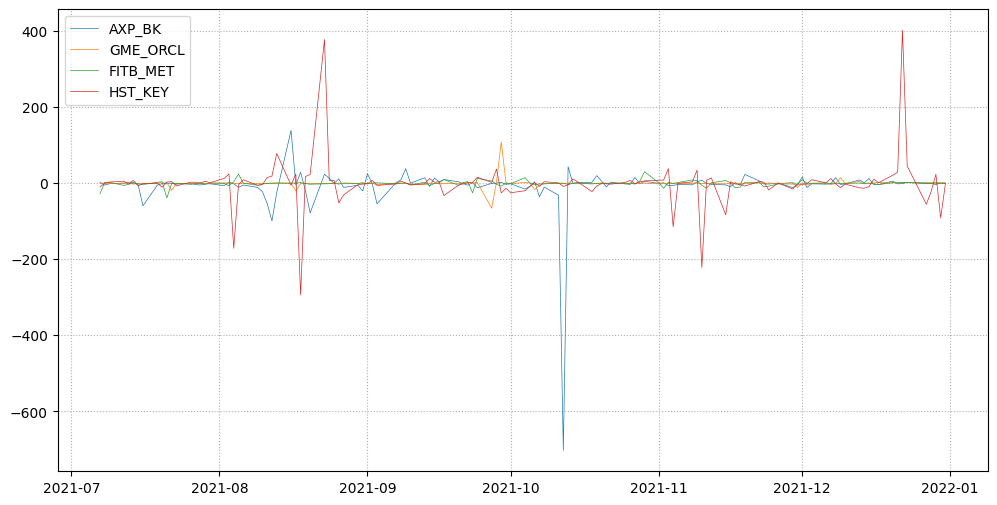

In [321]:
data0, _ = filter_pairs_df(validate_df, updated_cluster_vol_watchlist)
bt_df0 = data0.pivot(index = 'date', columns = 'ticker', values = 'close')
bt_df0.dropna(axis=1, thresh=100, inplace=True)
bt_df0.interpolate(inplace=True)
bt_df0.fillna(bt_df0.mean(), inplace=True)

returns0 = backtest_pairs_trading(bt_df0, updated_cluster_vol_watchlist, cluster_vol_spread_df)
returns0 = returns1.pct_change().dropna(axis=0, how="all")
returns0.add(1).cumprod().sub(1).plot(figsize=(12,6), lw=0.5)
plt.grid(ls='dotted')

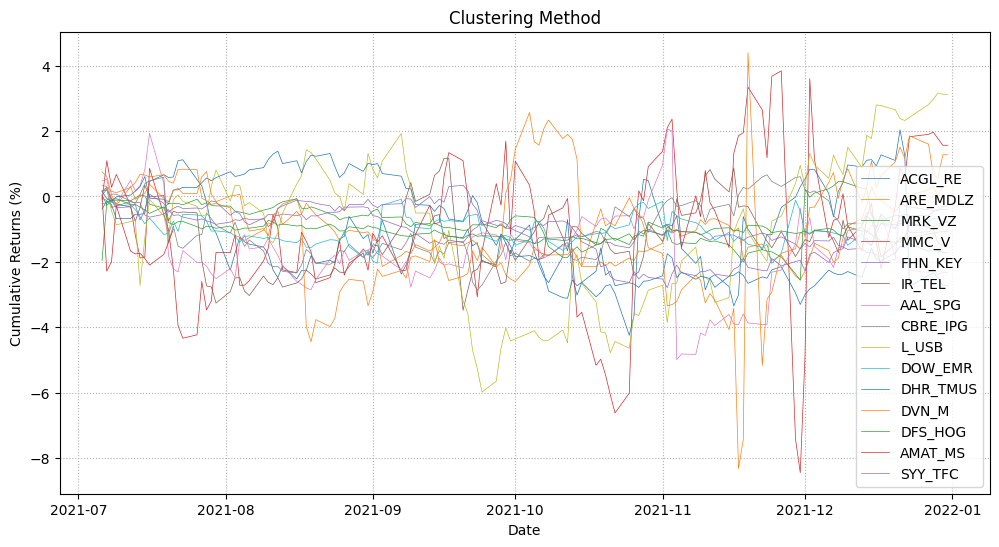

In [451]:
data1, _ = filter_pairs_df(validate_df, updated_cluster_watchlist)
bt_df1 = data1.pivot(index = 'date', columns = 'ticker', values = 'close')
bt_df1.dropna(axis=1, thresh=100, inplace=True)
bt_df1.interpolate(inplace=True)
bt_df1.fillna(bt_df1.mean(), inplace=True)

returns1 = backtest_pairs_trading(bt_df1, updated_cluster_watchlist, cluster_spread_df)
returns1 = returns1.pct_change().dropna(axis=0, how="all")
returns1.add(1).cumprod().sub(1).plot(figsize=(12,6), lw=0.5)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.title("Clustering Method")
plt.grid(ls='dotted')
plt.show()

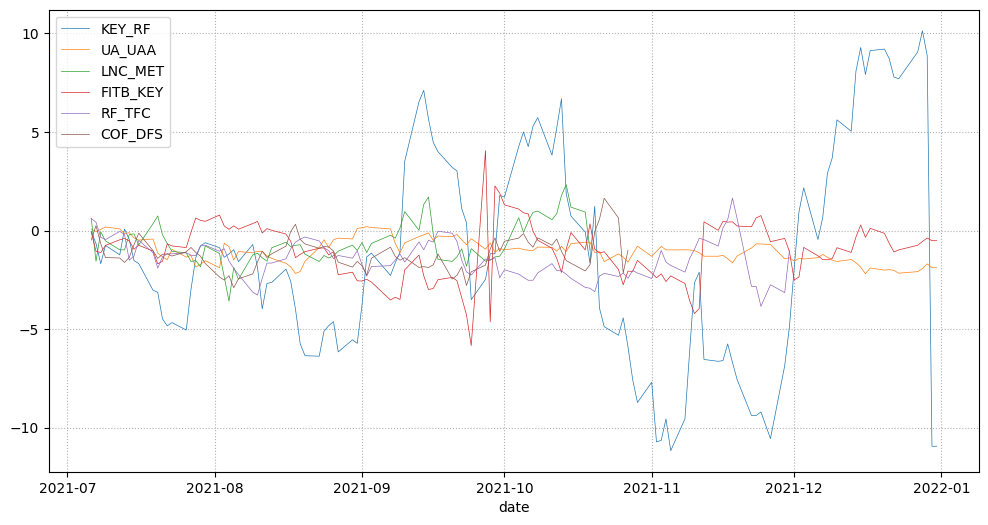

In [332]:
data2, _ = filter_pairs_df(validate_df, updated_corr_watchlist)
bt_df2 = data2.pivot(index = 'date', columns = 'ticker', values = 'close')
bt_df2.dropna(axis=1, thresh=100, inplace=True)
bt_df2.interpolate(inplace=True)
bt_df2.fillna(bt_df2.mean(), inplace=True)

returns2 = backtest_pairs_trading(bt_df2, updated_corr_watchlist, corr_spread_df)
returns2 = returns2.pct_change().dropna(axis=0, how="all")
returns2.add(1).cumprod().sub(1).plot(figsize=(12,6), lw=0.5)
plt.grid(ls='dotted')

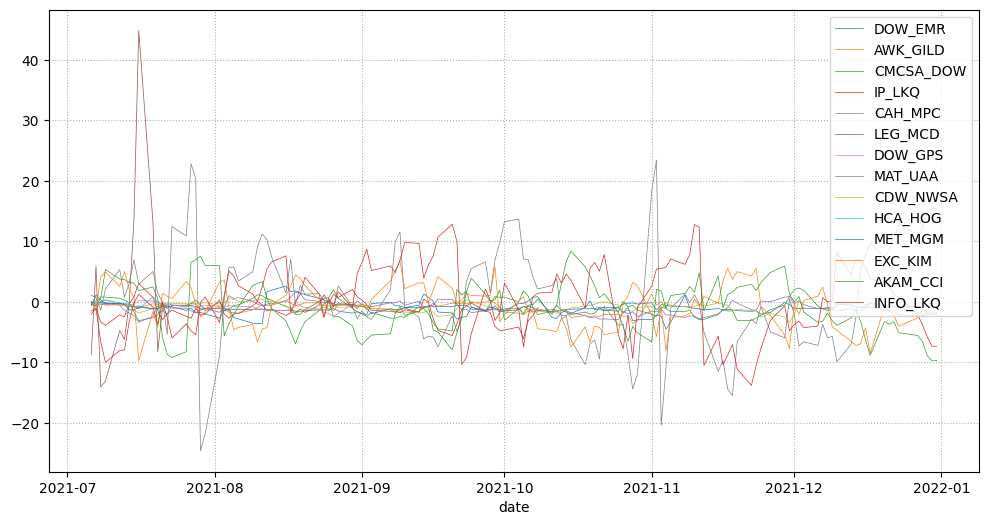

In [333]:
data3, _ = filter_pairs_df(validate_df, updated_coint_watchlist)
bt_df3 = data3.pivot(index = 'date', columns = 'ticker', values = 'close')
bt_df3.dropna(axis=1, thresh=100, inplace=True)
bt_df3.interpolate(inplace=True)
bt_df3.fillna(bt_df3.mean(), inplace=True)

returns3 = backtest_pairs_trading(bt_df3, updated_coint_watchlist, coint_spread_df)
returns3 = returns3.pct_change().dropna(axis=0, how="all")
returns3.add(1).cumprod().sub(1).plot(figsize=(12,6), lw=0.5)
plt.grid(ls='dotted')

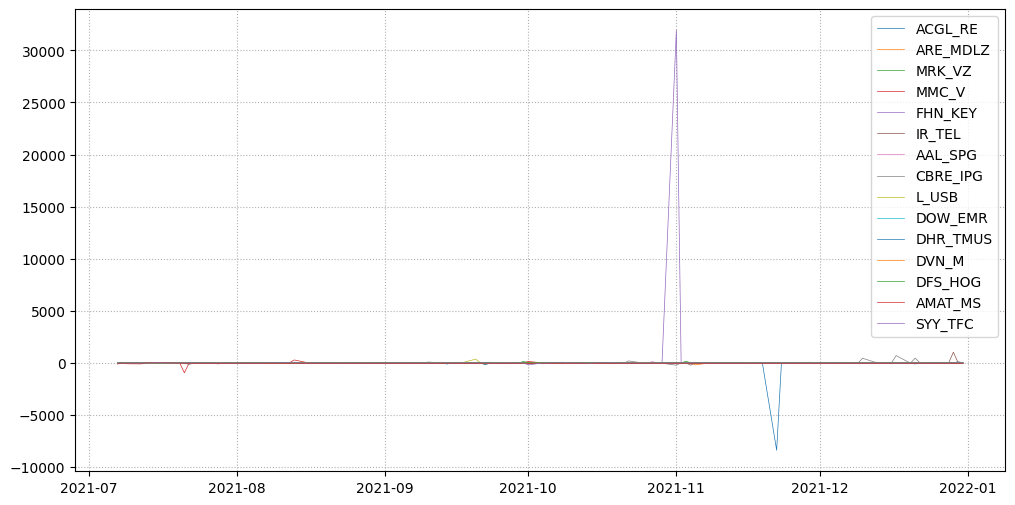

In [449]:
data4, _ = filter_pairs_df(validate_df, updated_cluster_mc_watchlist)
bt_df4 = data4.pivot(index = 'date', columns = 'ticker', values = 'close')
bt_df4.dropna(axis=1, thresh=100, inplace=True)
bt_df4.interpolate(inplace=True)
bt_df4.fillna(bt_df4.mean(), inplace=True)

returns4 = backtest_pairs_trading(bt_df4, updated_cluster_mc_watchlist, cluster_mc_spread_df)
returns4 = returns1.pct_change().dropna(axis=0, how="all")
returns4.add(1).cumprod().sub(1).plot(figsize=(12,6), lw=0.5)
plt.grid(ls='dotted')

In [334]:
(returns0.add(1).cumprod().sub(1)).tail(1)

,AXP_BK,GME_ORCL,FITB_MET,HST_KEY
2021-12-31,-1.0,1.681047,-1.0,-1.0


In [335]:
(returns1.add(1).cumprod().sub(1)).tail(1)

,ACGL_RE,ARE_MDLZ,MRK_VZ,MMC_V,FHN_KEY,IR_TEL,AAL_SPG,CBRE_IPG,L_USB,DOW_EMR,DHR_TMUS,DVN_M,DFS_HOG,AMAT_MS,SYY_TFC
2021-12-31,-2.724354,0.31065,-0.305186,1.5648,-0.399481,-1.499362,-2.318417,-0.758383,3.124294,-0.756436,-1.706142,1.276024,-1.078411,NaN,-0.79476


In [336]:
(returns2.add(1).cumprod().sub(1)).tail(1)

,KEY_RF,UA_UAA,LNC_MET,FITB_KEY,RF_TFC,COF_DFS
date,,,,,,
2021-12-31,-10.942229,-1.889022,NaN,-0.516724,NaN,NaN


In [337]:
(returns3.add(1).cumprod().sub(1)).tail(1)

,DOW_EMR,AWK_GILD,CMCSA_DOW,IP_LKQ,CAH_MPC,LEG_MCD,DOW_GPS,MAT_UAA,CDW_NWSA,HCA_HOG,MET_MGM,EXC_KIM,AKAM_CCI,INFO_LKQ
date,,,,,,,,,,,,,,
2021-12-31,-0.756436,NaN,-1.926103,NaN,-2.12748,NaN,NaN,15.451588,NaN,NaN,NaN,-1.689424,-9.722514,-7.327747


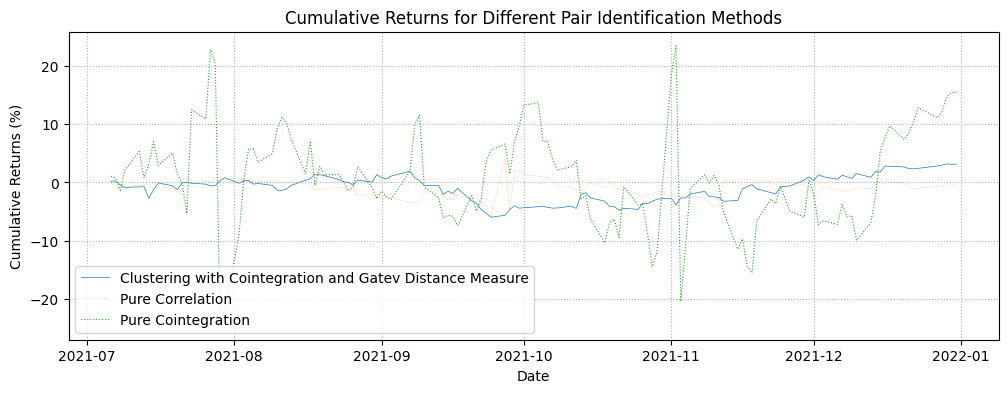

In [354]:
ax = (returns1["L_USB"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=0.5, label="Clustering with Cointegration and Gatev Distance Measure")
# (returns0["GME_ORCL"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=0.3, ls='dotted', label="Clustering with Volume", ax=ax)
(returns2["FITB_KEY"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=0.3, ls='dotted', label="Pure Correlation", ax=ax)
(returns3["MAT_UAA"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=0.8, ls='dotted', label="Pure Cointegration", ax=ax)
plt.legend()
plt.title("Cumulative Returns for Different Pair Identification Methods")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.grid(ls='dotted')
plt.show()

In [464]:
#AMAT_MS (Applied Materials and Morgan Stanley)
snp500[snp500.ticker == 'MS'].head(1)

,date,gvkey,iid,ticker,company name,ADR Ratio - Daily,shares outstanding,volume,close,high,...,open,GIC Groups,GIC Industries,GIC Sectors,GIC Sub-Industries,NAIC,SIC,S&P Industry Sector Code,S&P Economic Sector Code,market cap
1348078,2010-01-04,12124,1,MS,MORGAN STANLEY,NaN,1.359433e+09,20335480.0,30.91,31.968,...,30.7,4020,402030,40,40203020,523110,6211,850.0,800.0,4.202007e+10


In [ ]:
#GME_ORCL (Gamestop and Oracle)
snp500[snp500.ticker == 'GME']

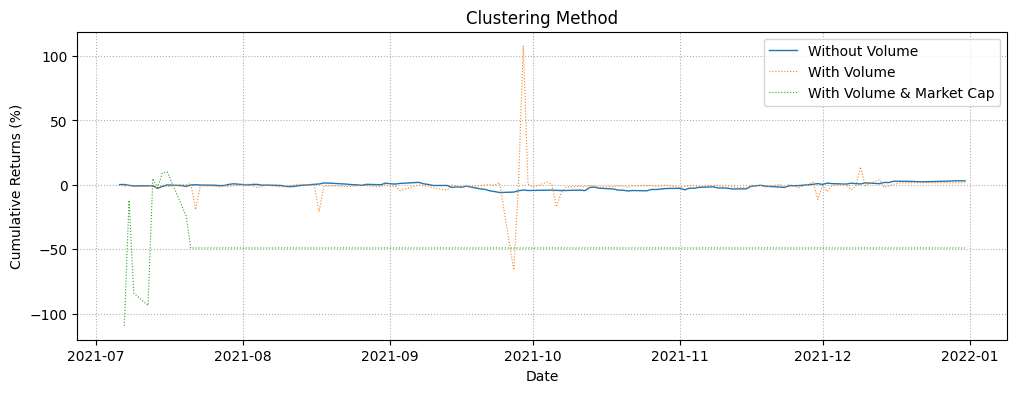

In [443]:
# plt.figure()
ax = (returns1["L_USB"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=1, label="Without Volume")
(returns0["GME_ORCL"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=0.8, ls='dotted', label="With Volume", ax=ax)
(returns4["AMAT_MS"].add(1).cumprod().sub(1)).plot(figsize=(12,4), lw=0.8, ls='dotted', label="With Volume & Market Cap", ax=ax)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (%)")
plt.title("Clustering Method")
plt.grid(ls='dotted')
plt.show()